<h3>Import Required Libraries</h3>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage


<h3>Load and Preprocess the Dataset</h3>

In [4]:
df = pd.read_csv('s3://knodax-ml-datasets/customer_clustering_dataset.csv')  # Replace with your S3 path or local path
features = df[['Age', 'AnnualIncome', 'SpendingScore']]  # Adjust based on your dataset
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)


<h3>Generate a Dendrogram for Hierarchical Clustering</h3>

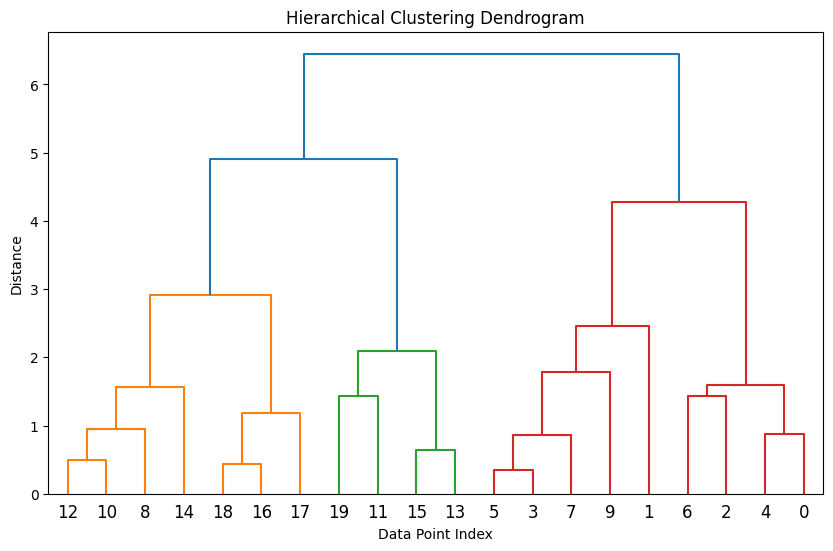

In [5]:
linked = linkage(scaled_features, method='ward')
plt.figure(figsize=(10, 6))
dendrogram(linked, labels=df.index.tolist(), orientation='top', distance_sort='descending')
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Data Point Index')
plt.ylabel('Distance')
plt.show()


<h4>What the Dendrogram Shows</h4>
<li>X-axis (Data Point Index): Each number (e.g., 12, 10, 8...) represents an individual data point (e.g., a customer) in your dataset.</li>

<li>Y-axis (Distance): This represents the distance (or dissimilarity) between clusters when they are merged. The higher the connection, the more dissimilar the clusters are.</li>

<h4>How to Read It</h4>
<li>Start from the bottom: Each point starts as its own cluster.  </li>
<li>Merge upward: As you go up, similar points/clusters are joined together.  </li><br>
Height matters: The height where two branches merge reflects how different those clusters are.<br>
    <li>Low merge = very similar.</li>
    <li>High merge = less similar.</li>


<h4>Example Interpretation</h4>
<li>Points 12 and 10 are merged first at a low distance, meaning they're very similar.</li>
<li>Then they’re merged with point 8, and so on.</li>
<li>At the very top, all the clusters are finally merged into one (that’s the final root).</li>



<h4>How Many Clusters?</h4>
To decide on the number of clusters:
<li>Imagine drawing a horizontal line across the dendrogram.</li>
<li>Each vertical line it crosses corresponds to one cluster.</li>
<li>A good cut is where there's the largest vertical gap between merges — often called the largest linkage distance jump.</li>

<h5>For this dendrogram:<h5>
If you draw a horizontal line around y = 4.5, you'd get 3 main clusters (each major branch in a different color: orange, green, red).

<h4>In Summary</h4>
<li>This diagram shows which points are similar and how they are grouped step by step.</li>
<li>The higher the merge, the less similar the clusters.</li>
<li>Use the height gap to decide the number of clusters — in this case, 3 looks like a solid choice.</li>

<h4>Why Data Points Are Labeled 0 to 19 Instead of 1001 to 1020</h4>
The dendrogram (and most clustering algorithms in libraries like scipy, sklearn, or seaborn) uses the row index of the data, not the actual value of the CustomerID column. So if your dataset looks like this:

| Row Index | CustomerID | AnnualIncome | SpendingScore | Age |
| --------- | ---------- | ------------ | ------------- | --- |
| 0         | 1001       | ...          | ...           | ... |
| 1         | 1002       | ...          | ...           | ... |
| ...       | ...        | ...          | ...           | ... |
| 19        | 1020       | ...          | ...           | ... |


Then the dendrogram will label data points from 0 to 19, because that’s how Python sees them internally — by their position in the DataFrame, not by CustomerID.

<h4>What to Do if You Want to Show CustomerID Instead</h4>
If you want to label the dendrogram using actual CustomerID values instead of row numbers, here's how to do it:

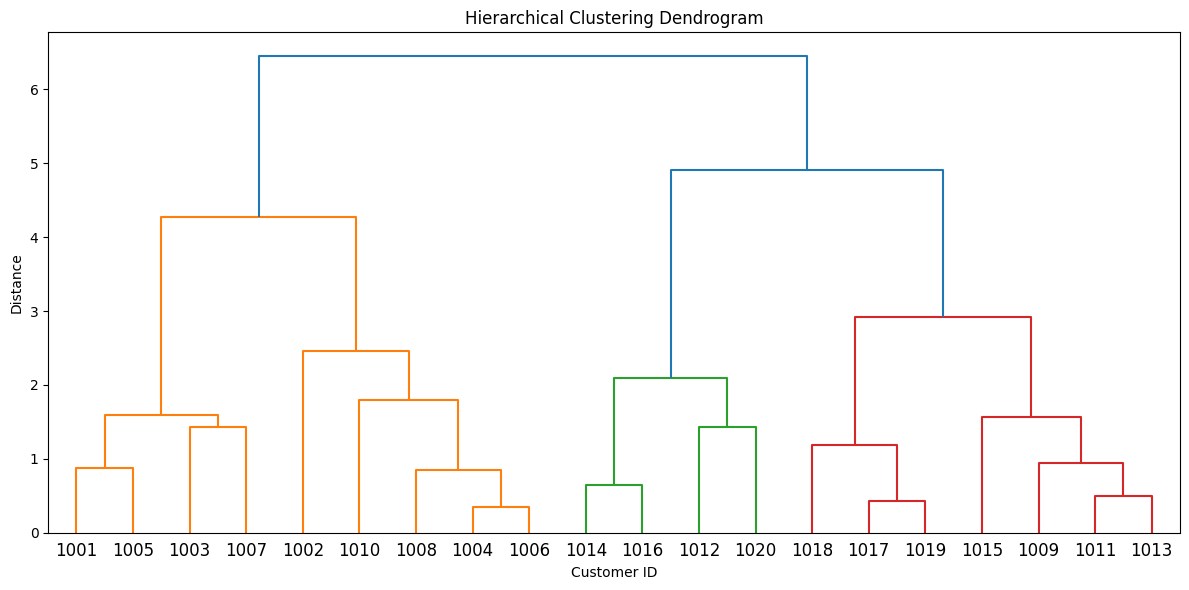

In [6]:
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

# Assuming df is your DataFrame and you've selected only numeric features
Z = linkage(scaled_features, method='ward')  # or whatever linkage method you're using

# Use CustomerID for labels
labels = df['CustomerID'].tolist()

plt.figure(figsize=(12, 6))
dendrogram(Z, labels=labels)
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Customer ID")
plt.ylabel("Distance")
plt.tight_layout()
plt.show()


<h4>How to Spot the Largest Vertical Jump</h4>
In a dendrogram:
<li>The vertical lines represent the distance (dissimilarity) between clusters being merged.</li>
<li>A large vertical jump between two horizontal lines means that two very different clusters are being merged — this is a good place to "cut" the tree.</li>

In the Dendrogram, at the very top.
The biggest vertical jump is the final merge around distance ≈ 6.5, which connects the left block (orange) + middle block (green) with the right block (red). The previous large merges happen around ~4.3–5.0, so the gap (~6.5 − ~5.0 ≈ 1.5–2 units) is the largest.

So, cut the dendrogram a little below ~5.0. That yields 3 clusters:
<li>Left (orange): 1001, 1005, 1003, 1007, 1002, 1010, 1008, 1004, 1006</li>
<li>Middle (green): 1014, 1016, 1012, 1020</li>
<li>Right (red): 1018, 1017, 1019, 1015, 1009, 1011, 1013</li>

(Exact IDs per color may vary slightly depending on your plotting code, but that’s the idea.)

There is also significant vertical jump between ~2.9 and ~4.9, and it’s the second-largest jump in the dendrogram.<br>
Let's Compare the Two Jumps:<br>
Final Merge (Largest Jump):
<li>From ~4.9 to ~6.5</li>
<li>Merges two large cluster branches (left+middle with right)</li>
<li>Cutting below ~4.9 gives you 3 clusters</li><br>

Middle Merge (Second-Largest Jump):
<li>From ~2.9 to ~4.9</li>
<li>Occurs when smaller clusters (left and middle) are merged</li>
<li>Cutting just below ~2.9 would result in 5 clusters</li><br>

So, What Does the Jump at 2.9–4.9 Mean? <br>
<li>That jump represents another natural grouping, where 5 moderately distinct clusters exist before they're forced to combine into 3.</li>
<li>Choosing to cut just below 2.9 will preserve more fine-grained clusters, which might make sense in detailed segmentation tasks (like marketing personas or behavior groups).</li><br>

Summary<br>
Distance Range	Vertical Jump	#Clusters if You Cut Below<br>
~4.9 to ~6.5	Largest	3 clusters<br>
~2.9 to ~4.9	Second-largest	5 clusters<br>

<li>Choose 3 clusters for simplicity and general grouping.
<li>Choose 5 clusters if you want more detailed segmentation.

<h3>(Optional) Generate an Elbow Plot for Cluster Evaluation</h3>

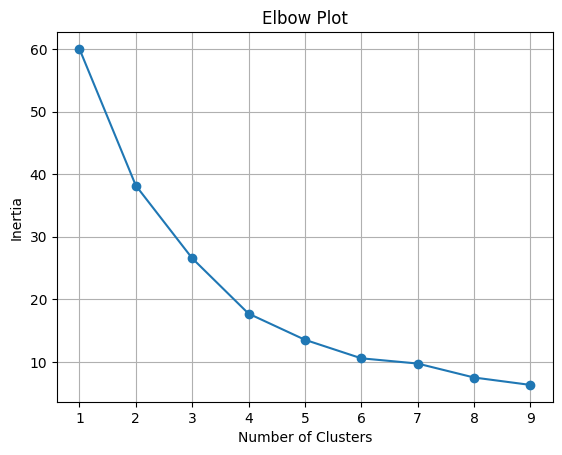

In [7]:
from sklearn.cluster import KMeans

inertia = []
for k in range(1, 10):
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(scaled_features)
    inertia.append(km.inertia_)

plt.plot(range(1, 10), inertia, marker='o')
plt.title('Elbow Plot')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()


You're looking at an Elbow Plot, which is commonly used to determine the optimal number of clusters (k) for K-Means clustering.

<h4>What the Plot Shows</h4>

<ul>
  <li>
    <strong>X-axis (Number of Clusters):</strong>
    Values from 1 to 9 — the number of clusters (<em>k</em>) used in K-Means.
  </li>
  <li>
    <strong>Y-axis (Inertia):</strong>
    Also called <em>within-cluster sum of squares (WCSS)</em


<h4>How to Interpret It</h4>

<p>
  The goal is to find the point where the decrease in inertia slows down significantly — the so-called <strong>"elbow"</strong>.
</p>

<p><strong>Before the elbow:</strong> Adding clusters significantly improves the model.</p>
<p><strong>After the elbow:</strong> Adding clusters yields minimal improvement (diminishing returns).</p>

<h4>In This Plot:</h4>
<ul>
  <li>There's a sharp drop from <em>k = 1</em> to <em>k = 3</em></li>
  <li>The curve starts to flatten after <em>k = 3</em> or <em>k = 4</em></li>
  <li>The elbow appears around <em>k = 3</em> or <em>4</em></li>
</ul>

<h4>Conclusion:</h4>
<p>The optimal number of clusters is likely <strong>3</strong> or <strong>4</strong>, based on the elbow point.</p>

<p><strong>You can choose:</strong></p>
<ul>
  <li><em>k = 3</em> if you want general segmentation</li>
  <li><em>k = 4</em> if you want slightly more granularity without overfitting</li>
</ul>

<h3>Apply Agglomerative Clustering</h3>
Choose an optimal cluster count (e.g., 3 based on dendrogram or elbow plot) and fit the model.

In [8]:
agglo = AgglomerativeClustering(n_clusters=3)
df['cluster'] = agglo.fit_predict(scaled_features)


<h3>Visualize Cluster Assignments</h3>
Use a 2D scatter plot to view clusters based on two selected features.

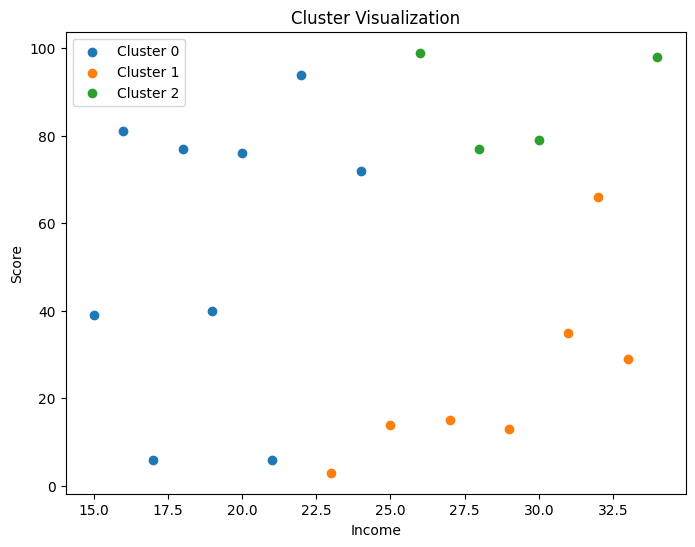

In [9]:
plt.figure(figsize=(8, 6))
for cluster_id in sorted(df['cluster'].unique()):
    subset = df[df['cluster'] == cluster_id]
    plt.scatter(subset['AnnualIncome'], subset['SpendingScore'], label=f'Cluster {cluster_id}')

plt.xlabel('Income')
plt.ylabel('Score')
plt.title('Cluster Visualization')
plt.legend()
plt.show()


<h3>"Apply Agglomerative Clustering" Means:</h3>
<p>
  You're running a <strong>bottom-up hierarchical clustering algorithm</strong> where:
</p>
<p>
  Each data point starts in its own cluster, and then the algorithm iteratively merges the closest clusters until a desired number of clusters is formed.
</p>

<h4>In Simple Terms:</h4>
<p>You have a set of points (e.g., customer data).</p>
<p>Agglomerative Clustering groups them step by step:</p>
<ol>
  <li>Start with every point as its own cluster.</li>
  <li>Find the two closest clusters and merge them.</li>
  <li>Repeat until you have the desired number of clusters (say, <em>k = 3</em>).</li>
</ol>

<h4>Why Use It?</h4>
<ul>
  <li>It's part of <strong>Hierarchical Clustering</strong> (the most common form).</li>
  <li>You don’t need to specify the number of clusters in advance (optional).</li>
  <li>You can visualize it using a <strong>dendrogram</strong>.</li>
  <li>It's good for finding <strong>natural groupings</strong> in data (like customer segmentation, document grouping, etc.).</li>
</ul>


<h4>When You "Apply" It:</h4>
<ul>
  <li>You run the algorithm on your data.</li>
  <li>You get <strong>cluster labels</strong> for each point.</li>
  <li>
    You can <strong>visualize clusters</strong>, <strong>analyze them</strong>, or use them for
    downstream tasks (e.g., recommendation, marketing, anomaly detection).
  </li>
</ul>
